# Fine-Tune ViT for Image Classification with Hugging Face Transformers

- OWL-ViT (short for Vision Transformer for Open-World Localization) 

# References
- https://huggingface.co/blog/fine-tune-vit
- https://github.com/huggingface/transformers/issues/28778
- https://github.com/bwconrad/vit-finetune
- https://medium.com/@supersjgk/fine-tuning-vision-transformer-with-hugging-face-and-pytorch-df19839d5396

# Environment Setup

In [83]:
%%capture
!pip install -r ../requirements.txt

# Library

In [84]:
# PyTorch
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
# For dislaying images
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
# Loading dataset
from datasets import load_dataset
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
# Matrix operations
import numpy as np
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Objective

Fine-tune the pre-trained Vision Transformer (ViT) model, specifically the vit-base variant, on the CIFAR-10 dataset.
- The vit-base model has already been pre-trained on ImageNet-21k (14 million images, 21,000 classes) and fine-tuned on ImageNet-1k (1 million images, 1,000 classes).
- The model utilizes a patch size of 16x16 and is designed to process images of size 3x224x224.

Adapt the model for the CIFAR-10 dataset, which consists of:
- 10 output classes
- Images of size 3x32x32

# CIFAR-10 Data
- Loading and Splitting
- We are only using a small subset of the dataset, as this is intended for demonstration purpose.

In [85]:
train_ds, test_ds = load_dataset("cifar10", split=["train[:5000]","test[:1000]"])
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
train_ds, val_ds, test_ds

print(f"{train_ds.num_rows = }")
print(f"{val_ds.num_rows = }")
print(f"{test_ds.num_rows} = ")

train_ds.num_rows = 4500
val_ds.num_rows = 500
1000 = 


## Basic data exploration

In [86]:
print(f"{train_ds.features['label'] = }")
print(f"{train_ds.num_rows = }")
print(f"{train_ds[0]} = ")
# train_ds.num_rows, train_ds[0]

train_ds.features['label'] = ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)
train_ds.num_rows = 4500
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F6EB2673970>, 'label': 5} = 


In [87]:
# Dictionary to encode the labels into numbers, both ways
label_encoding = dict((k,v) for k,v in enumerate(trainds.features['label'].names))
label_decoding = dict((v,k) for k,v in enumerate(trainds.features['label'].names))
label_encoding

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

# Plotting the image
- displaying an image and its corresponding label

horse


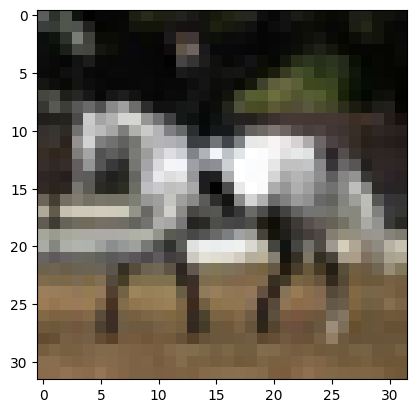

In [88]:
index = 1
img, label = train_ds[index]['img'], label_encoding[train_ds[index]['label']]
print(label)
plt.imshow(img)

# Image transform

In [91]:
# get parameters for image pre-transform before model
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
mu, sigma = processor.image_mean, processor.image_std #get default mu,sigma
size = processor.size
height = size['height']

# pre-transform the image to the pretrained data and model input size.
# resize 3x32x32 to 3x224x224 -> convert to Pytorch tensor -> normalize
_transf = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size['height']),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mu, std=sigma)
]) 

# apply transforms to PIL Image and store it to 'pixels' key
def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['img']]
    return arg

applying the transformation to each datasets

In [92]:
train_ds.set_transform(transf)
val_ds.set_transform(transf)
test_ds.set_transform(transf)

# Plotting the transformed image

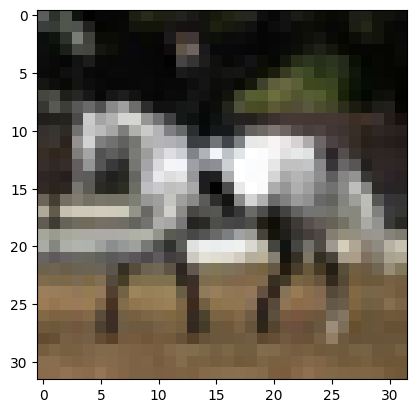

In [93]:
idx = 0
ex = train_ds[idx]['pixels']
ex = (ex+1)/2 #imshow requires image pixels to be in the range [0,1]
exi = ToPILImage()(ex)
plt.imshow(img)
plt.show()

# Original

In [124]:
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name)
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Load an image (you can replace this with your own image)
# image_path = "path/to/your/image.jpg"
# image = feature_extractor(images=image_path, return_tensors="pt")

# Forward pass through the model
outputs = model(train_ds[idx]['pixels'].unsqueeze(0))
logits = outputs.logits

# Get the predicted class label
predicted_class = torch.argmax(logits, dim=1).item()

# Print the predicted class label
print(f"Predicted class label: {predicted_class}")

print(model.classifier)

Predicted class label: 153
Linear(in_features=768, out_features=1000, bias=True)


# Fine-tuning

In [ ]:
# with torchvision method of initiatization , we could intialize a pretrained model with a replaced classifier head
model = ViTForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True, id2label=label_encoding, label2id=label_decoding)
print(model.classifier)

# Setup

In [143]:
# help(TrainingArguments)

In [ ]:
args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
    report_to = None # disable W&B logging
)

In [ ]:
def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [19]:
trainer = Trainer(
    model,
    args, 
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [20]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.086432,0.976000
2,0.446600,0.070623,0.982000
3,0.025100,0.072062,0.982000


TrainOutput(global_step=1350, training_loss=0.17576898089161624, metrics={'train_runtime': 734.4677, 'train_samples_per_second': 18.381, 'train_steps_per_second': 1.838, 'total_flos': 1.046216869705728e+18, 'train_loss': 0.17576898089161624, 'epoch': 3.0})

# Evaluation

In [106]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.09033887088298798, 'test_accuracy': 0.974, 'test_runtime': 12.7867, 'test_samples_per_second': 78.206, 'test_steps_per_second': 19.552}


In [111]:
label_encoding[np.argmax(outputs.predictions[0])], label_encoding[outputs.label_ids[0]]

('cat', 'cat')

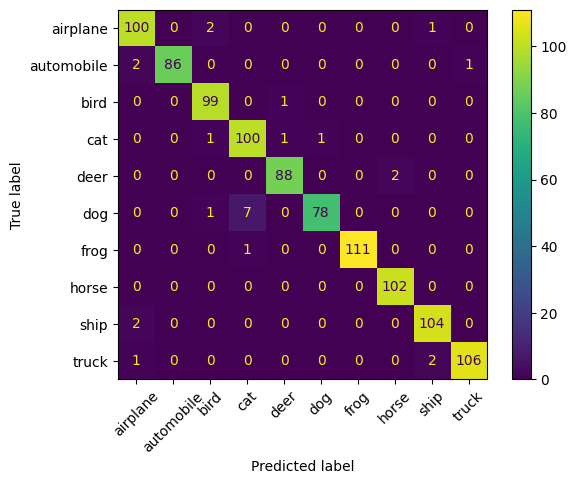

In [108]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = trainds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)